# Setup

In [ ]:
# !pip install statsmodels
# !pip install pmdarima
# !pip install matplotlib
# !pip install seaborn
# # !pip install "black[jupyter]"
# !pip3 install statsforecast
# # !pip install prophet
# !pip install --upgrade plotly
# !pip install learntools


In [1]:
# basic
import sys
from datetime import date
import pandas as pd
import numpy as np
from numpy import inf
import time 
from datetime import datetime

# plotting
from matplotlib import pyplot, dates
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Smoothing & Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tsa.ar_model import AR, ARResults, AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMAResults
from statsmodels.tsa.arima.model import  ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# prophet
import prophet

# forecast
from statsforecast import StatsForecast

# eval
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# descriptive tests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf


# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/axiao/.pyenv/versions/3.8.18/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%cd /Users/axiao/Desktop/Projects/projects/store_sales/data

holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions = pd.read_csv('transactions.csv',index_col='date', parse_dates=True)
oil =  pd.read_csv('oil.csv',index_col='date', parse_dates=True)
stores = pd.read_csv('stores.csv')

# train = pd.read_csv('train.csv', index_col='date', parse_dates=True)
train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)  # for re-run purposes
test = pd.read_csv('test.csv', index_col='date', parse_dates=True)

/Users/axiao/Desktop/Projects/projects/store_sales/data


# A Little More Data Engineering

In [4]:
tmp = train_engineered.reset_index()
tmp = tmp[['sales','family','store_nbr']].groupby(['family', 'store_nbr']).sum().reset_index()
tmp = tmp.sort_values(by='sales', ascending=False)

fam_lst = tmp[:2]['family'].tolist()
fam_lst.extend(tmp[-2:]['family'].tolist())
store_lst = tmp[:2]['store_nbr'].astype(str).tolist()
store_lst.extend(tmp[-2:]['store_nbr'].astype(str).tolist())

# create a list for the top 10 store num + family combo
i = 0
lst = []
while i < 4:
    uid = fam_lst[i] + '_' + store_lst[i]
    lst.append(uid)
    i += 1

train_engineered = train_engineered.reset_index()
train_engineered['uid'] = train_engineered['family'].astype(str)+'_'+train_engineered['store_nbr'].astype(str)

In [5]:
features_to_use = [
    'date','sales','onpromotion','oil_price', 'out_of_region',
    'is_year_start','is_year_end',  
    'day_of_year',
    'is_wknd','wageday'
]

In [6]:
df = train_engineered[train_engineered['uid']=='GROCERY I_44']

df = df[features_to_use]
df = df.set_index('date')

# set index freq
df = df.asfreq('d')
# print(test.index.freq)

# drop the nas for now
# df = df[~df.isna().any(axis=1)]

df[df.isna()] = 0 


# train test split
train = df.iloc[:round(len(df) * .8)+1]
test = df.iloc[round(len(df) * .8)+1:]


tmp = df
tmp = tmp.asfreq('D')

# extrapolate NAs
tmp[['sales','onpromotion','oil_price']]= tmp[['sales','onpromotion','oil_price']].interpolate(method='linear')

# exclude a col
# tmp = tmp.drop(columns=['if_holiday'], axis=1)

tmp.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-03-18', '2017-03-19', '2017-03-20', '2017-03-21',
               '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-25',
               '2017-03-26', '2017-03-27'],
              dtype='datetime64[ns]', name='date', length=1547, freq='D')

# First Look

## Stationarity

### Statistical Test

In [7]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    result = adfuller(timeseries.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        res = 'Stationary'
        print("\u001b[32mStationary\u001b[0m")
    else:
        res = 'Non-stationary'
        print("\x1b[31mNon-stationary\x1b[0m")


test_stationarity(tmp['sales'])

Results of Dickey-Fuller Test:
ADF Statistic: -4.792796
p-value: 0.000056
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


passes `adfuller` test - meaning that we don't have to difference this time series for its trend (i.e. `d=0`).

### Visual Test

but visually we can see that there're seasonal patterns in this TS

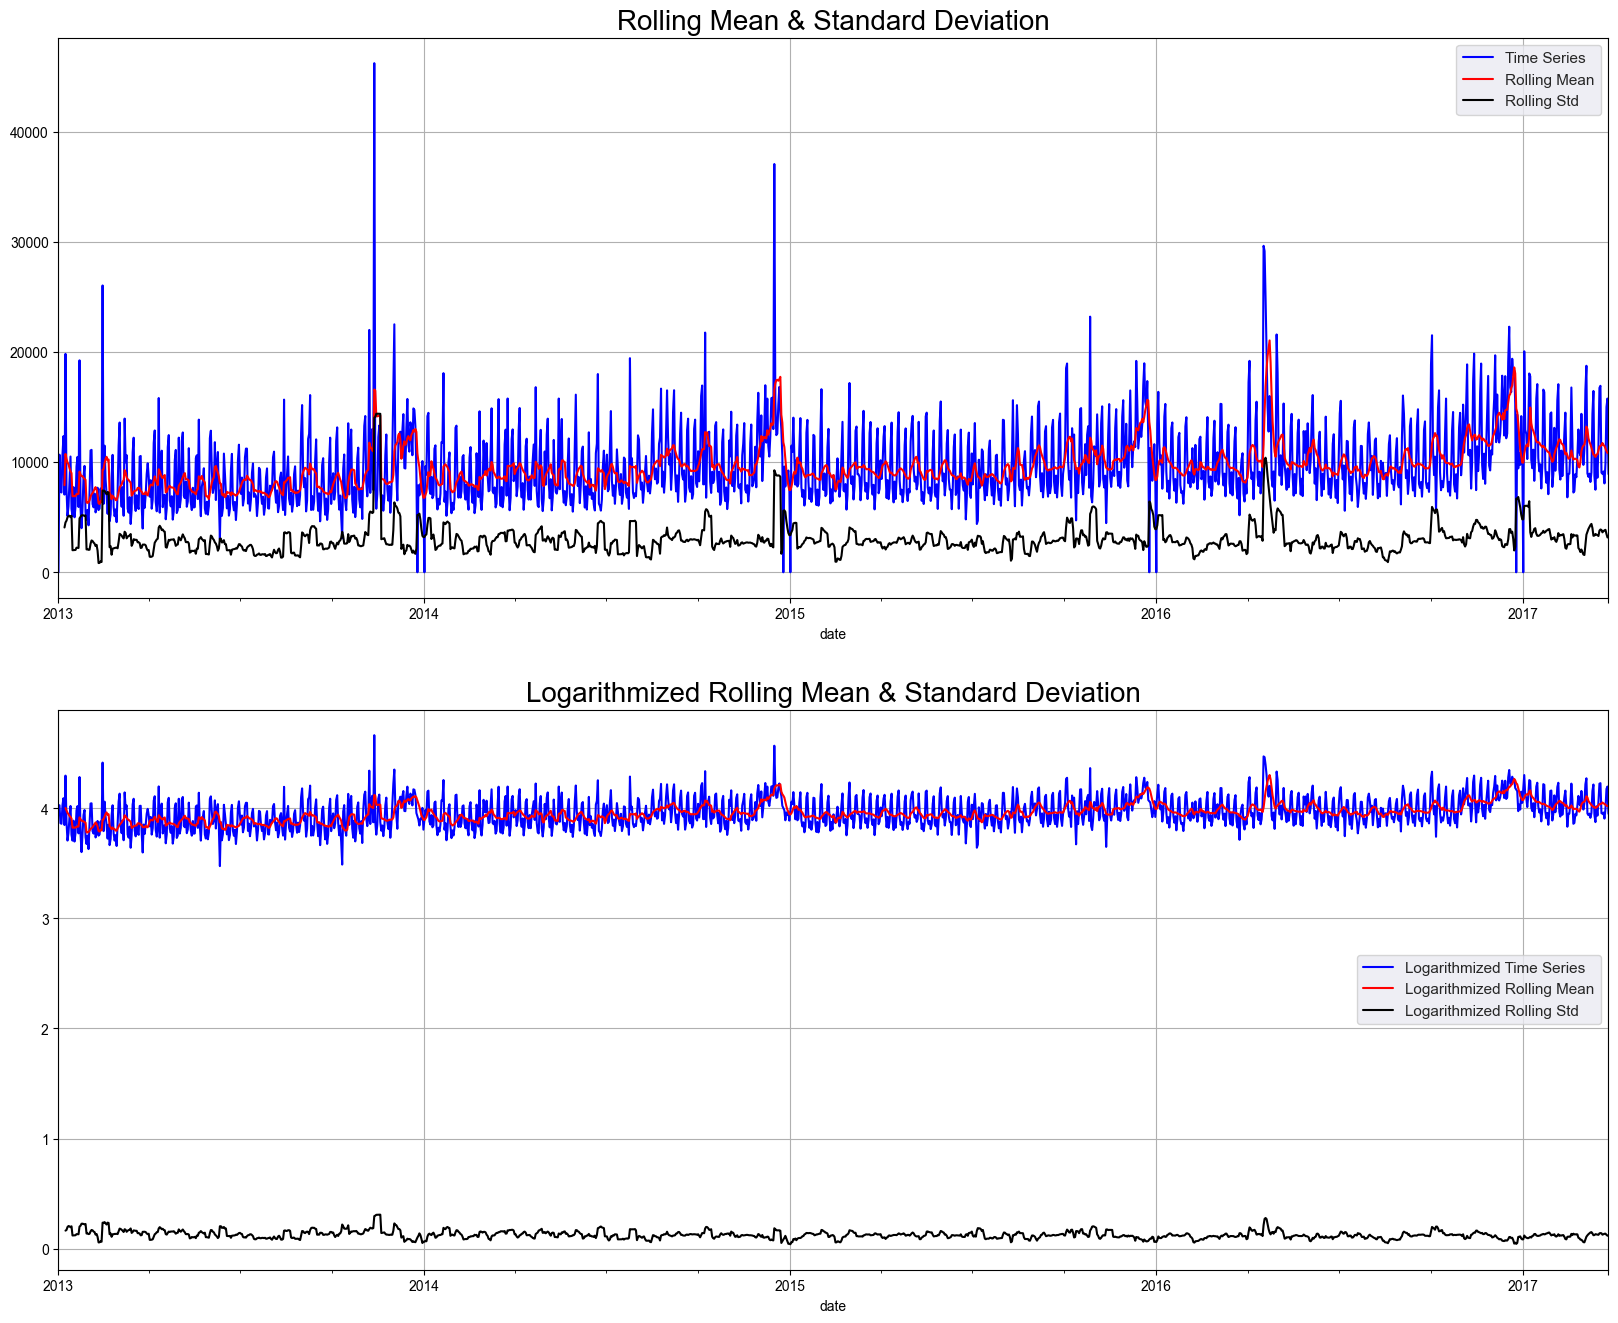

In [8]:
def plot_rolling_vars(timeseries):

    fig, ax = pyplot.subplots(2,1, figsize=(20,16))
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    #Plot rolling statistics:
    sns.set_theme()

    timeseries.plot(x=tmp.index, color='blue',label='Time Series', ax=ax[0])
    rolmean.plot(x=tmp.index, color='red', label='Rolling Mean', ax=ax[0])
    rolstd.plot(x=tmp.index, color='black', label = 'Rolling Std', ax=ax[0])
    ax[0].legend(loc='best')
    ax[0].set_title('Rolling Mean & Standard Deviation', fontsize=20)

    # plot stats on a log scale
    log_ts = np.log10(timeseries)
    log_ts = log_ts.replace([np.inf, -np.inf], np.nan) # replace inf & -inf with 0
    log_ts = log_ts.interpolate('linear') # interpolate
    log_rolmean = log_ts.rolling(7).mean()
    log_rolstd = log_ts.rolling(7).std()
    #Plot rolling statistics:
    log_ts.plot(x=tmp.index, color='blue',label='Logarithmized Time Series', ax=ax[1])
    log_rolmean.plot(x=tmp.index, color='red', label='Logarithmized Rolling Mean', ax=ax[1])
    log_rolstd.plot(x=tmp.index, color='black', label = 'Logarithmized Rolling Std', ax=ax[1])
    # sns.set_theme()
    ax[1].legend(loc='best')
    ax[1].set_title('Logarithmized Rolling Mean & Standard Deviation',fontsize=20)


plot_rolling_vars(tmp['sales'])

## `seasonal_decompose`

`model` param in `seasonal_decompose`:
- The additive model is useful when the seasonal variation is relatively constant over time. 
- The multiplicative model is useful when the seasonal variation increases over time. 
- [reference](https://online.stat.psu.edu/stat510/lesson/5/5.1#:~:text=How%20to%20Choose%20Between%20Additive,seasonal%20variation%20increases%20over%20time.)

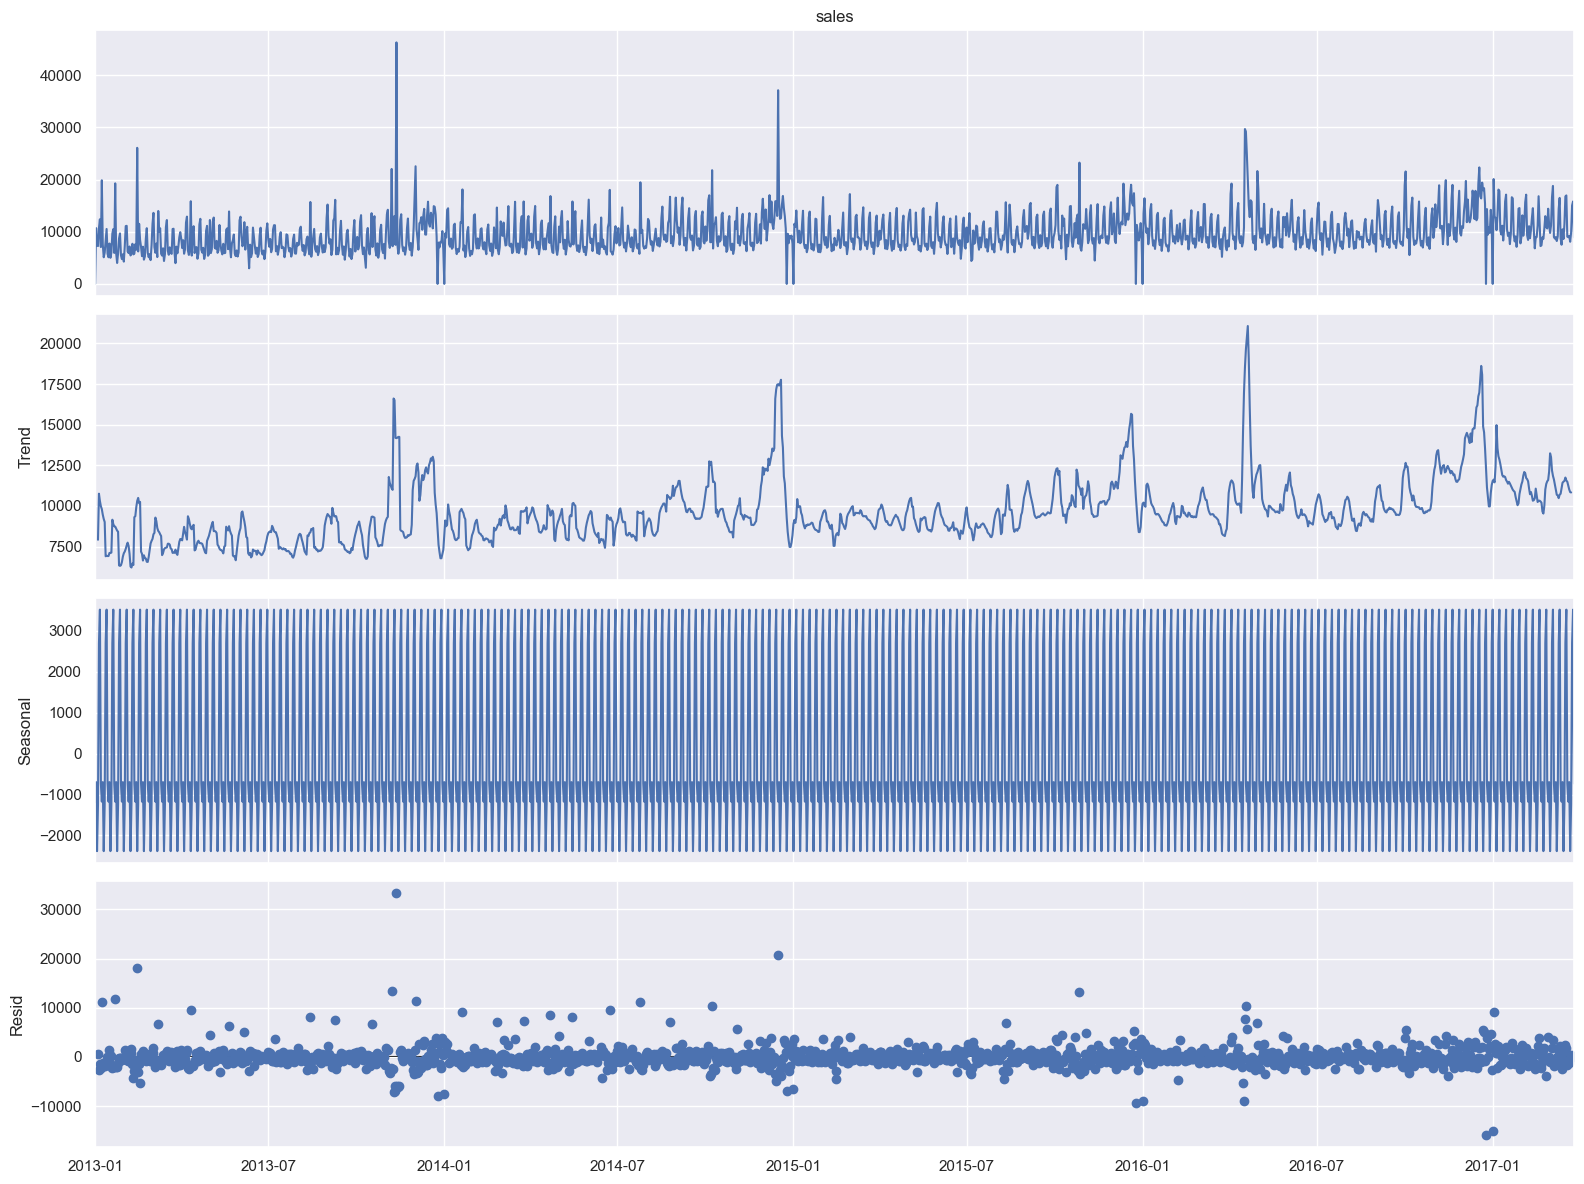

In [9]:
result = seasonal_decompose(tmp['sales'], model='additive', period=7)

sns.set_theme()
sns.set(rc={'figure.figsize':(16,12)})
fig = result.plot()
# fig.set_size_inches((16,15))
# fig.xticks(rotation=90)

Sales are at the lowest on the 3rd and peak on the 6th day of a week

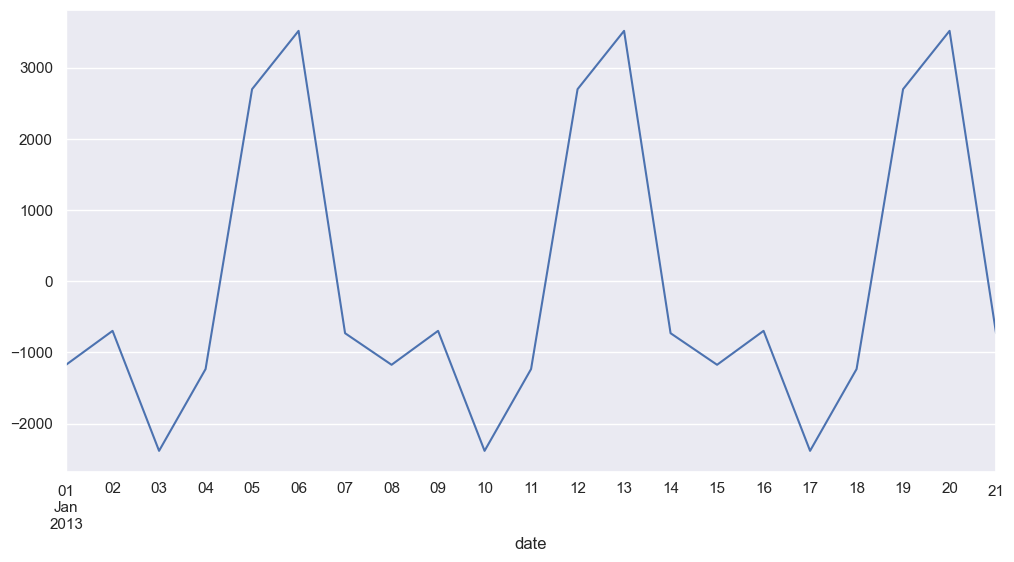

In [10]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})

result = seasonal_decompose(tmp['sales'], model='additive', period=7)
result.seasonal[:21].plot();

# Non-Seasonal Components

## De-Seasonalizing

In [11]:
result = seasonal_decompose(tmp['sales'], model='additive', period=7)
deseason_temp = tmp['sales'] - result.seasonal

Quick comparison of the original & deseasonalized Ts's

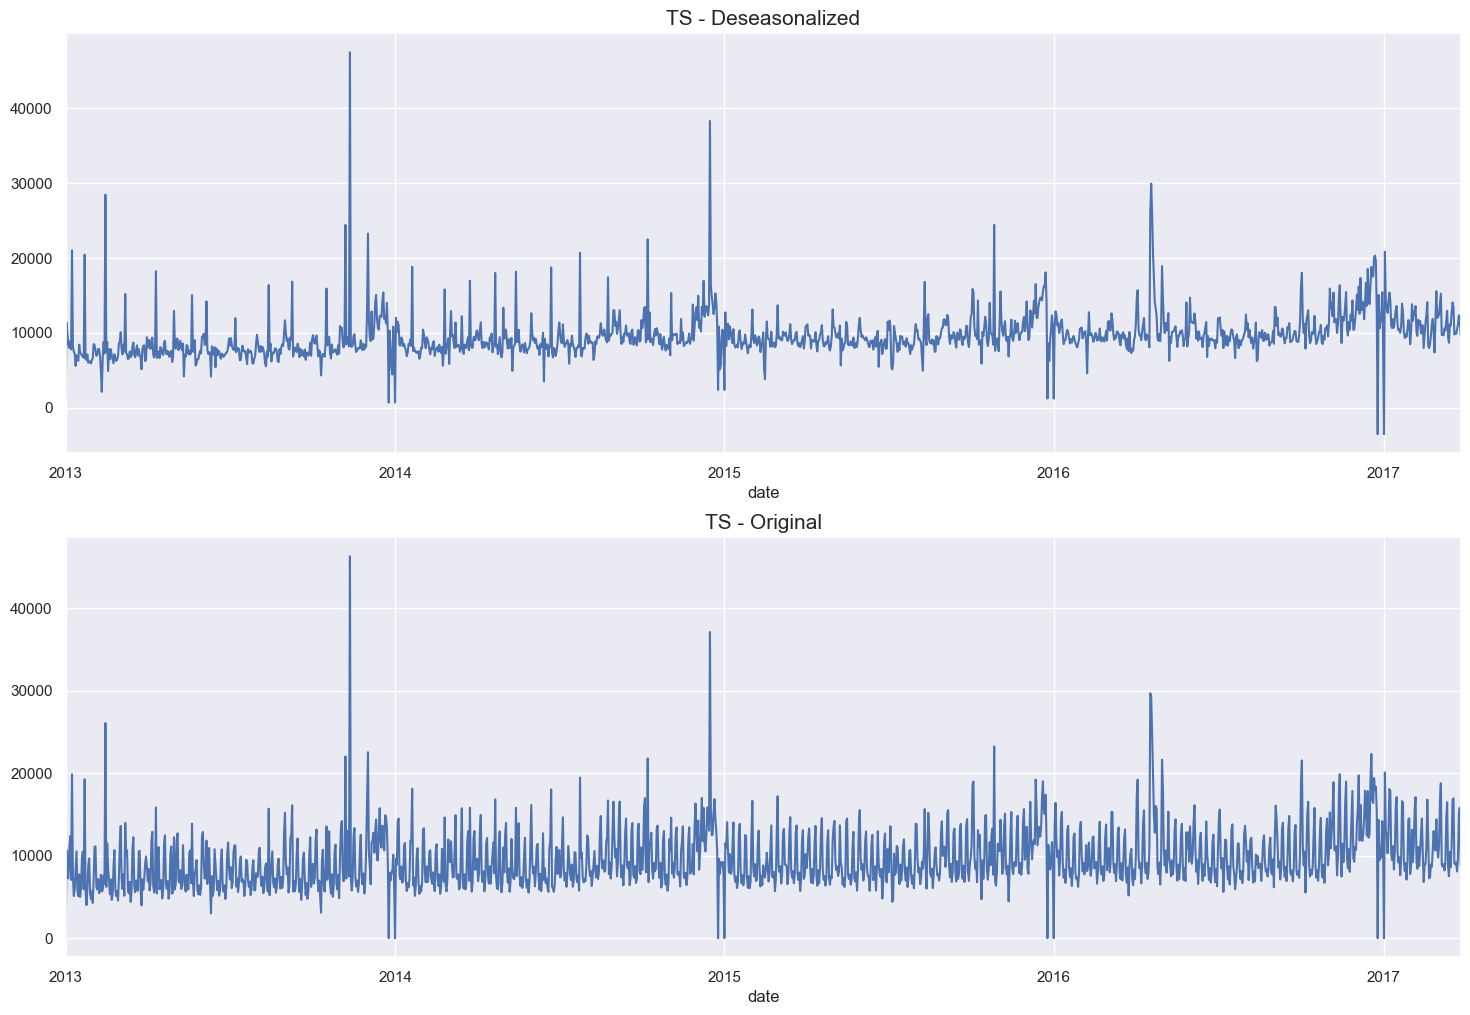

In [12]:
fig, ax = pyplot.subplots(2,1, figsize=(18,12))

deseason_temp.plot(x=tmp.index, ax=ax[0])
ax[0].set_title('TS - Deseasonalized', fontsize=15)

tmp['sales'].plot(x=tmp.index, ax=ax[1])
ax[1].set_title('TS - Original', fontsize=15);

still seeing some seasonality

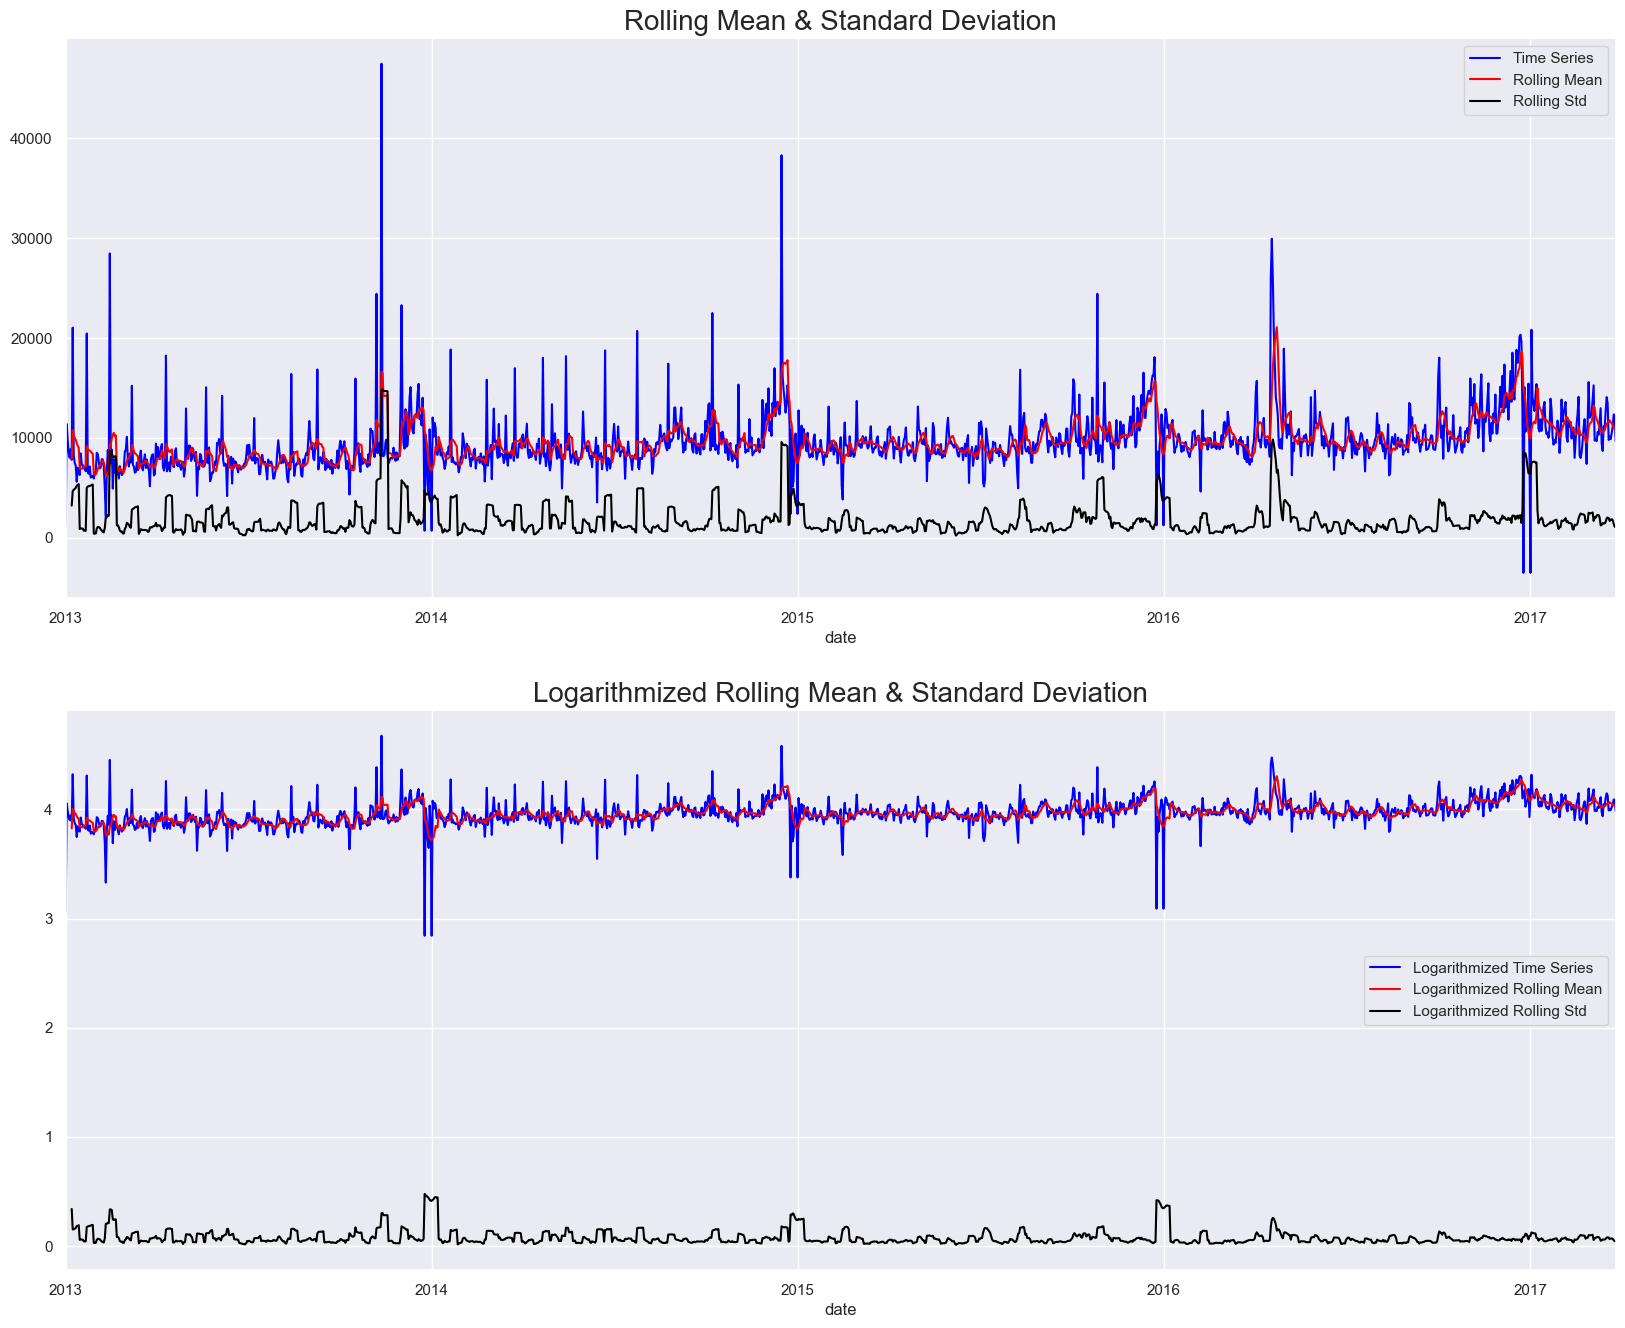

In [13]:

sns.set_theme()
sns.set(rc={'figure.figsize':(15,8)})

plot_rolling_vars(deseason_temp);

We're seeing positive autocorrelation out to a high number of lags. This means that we need higher order of differencing ([reference: rule 1](https://people.duke.edu/~rnau/arimrule.htm))

Also, visually we can see that since the data has strong seasonal patterns - another reason why seasonal differencing is necessary. ([reference](https://otexts.com/fpp2/stationarity.html))

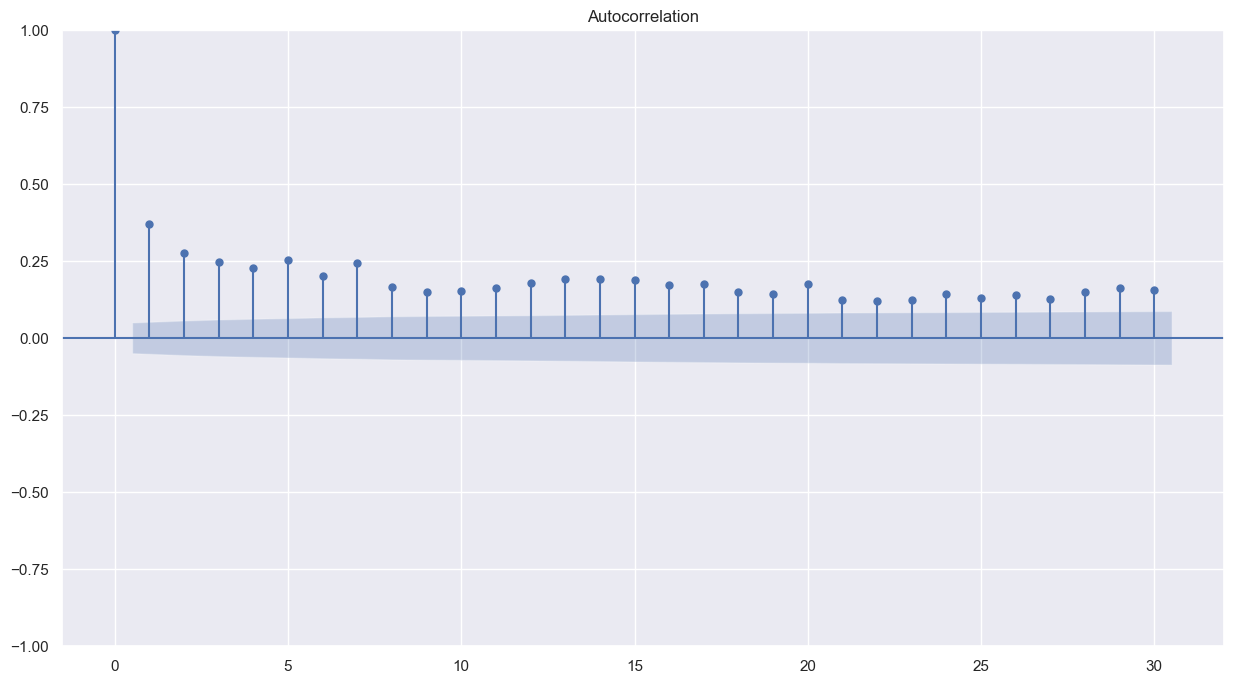

In [14]:
plot_acf(deseason_temp.dropna(),lags=30);

## Differencing

references:
- [Duke U: Summary of Rules for identifying ARIMA Models](https://people.duke.edu/~rnau/arimrule.htm)
- [Duke U: Seasonal Differencing](https://people.duke.edu/~rnau/Decision411_2007/Class10notes.htm)
- [Duke U: Seasonal differencing in ARIMA models|](https://people.duke.edu/~rnau/411sdif.htm)
- [Medium: How to Interpret ACF and PACF plots for Identifying AR, MA, ARMA, or ARIMA Models
](https://medium.com/@ooemma83/how-to-interpret-acf-and-pacf-plots-for-identifying-ar-ma-arma-or-arima-models-498717e815b6#:~:text=The%20basic%20guideline%20for%20interpreting,q%20for%20MA(q).)

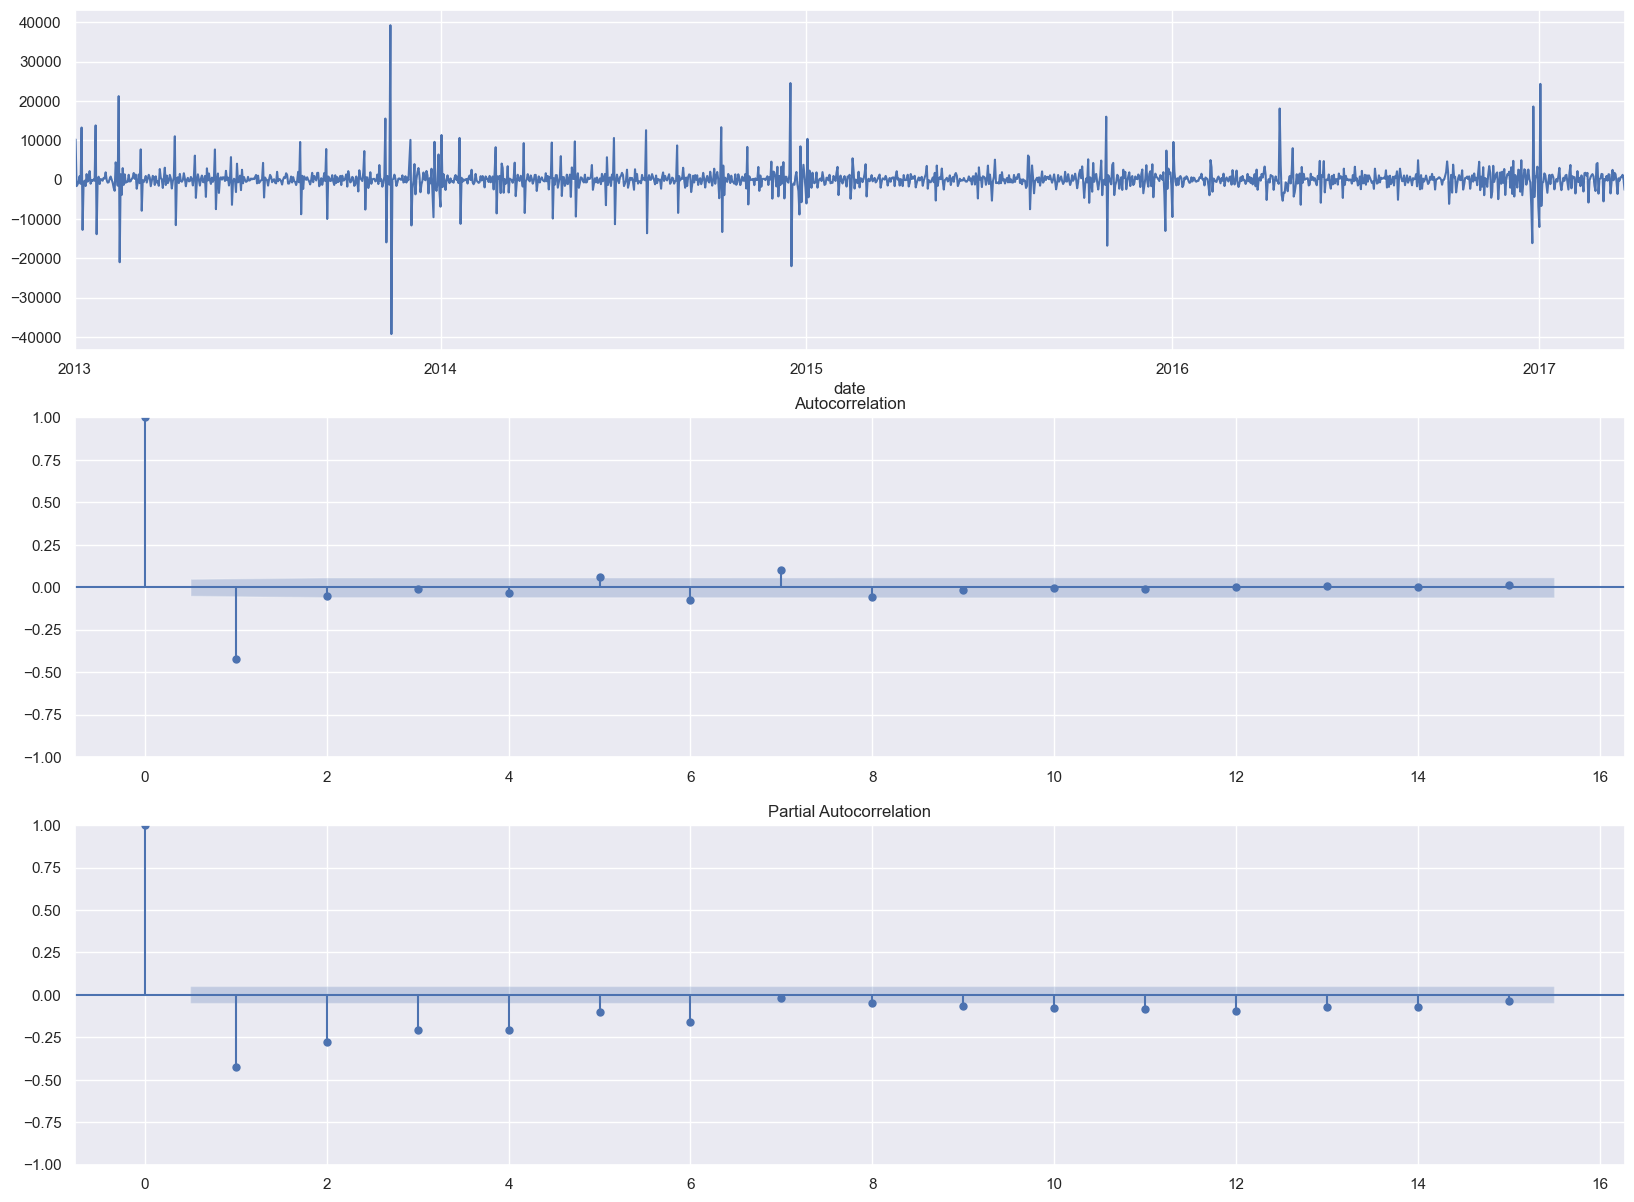

In [15]:
deseason_df = pd.DataFrame()
deseason_df['sales_deseason_diff'] = deseason_temp - deseason_temp.shift(1)

sns.set_theme()
# sns.set(rc={'figure.figsize':(12,6)})

fig, ax = pyplot.subplots(3,1, figsize=(20,15))
deseason_df['sales_deseason_diff'].plot(ax=ax[0])
plot_acf(deseason_df['sales_deseason_diff'].dropna(),lags=15,ax=ax[1])
plot_pacf(deseason_df['sales_deseason_diff'].dropna(),lags=15, ax=ax[2]);

- tail off at PACF - so we know it's an MA model
- ACF tells us the q:1

# Seasonal Component

## Stationarity (`D`)

In [18]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    # rolstd = pd.rolling_std(timeseries, window=7)

    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])


    result = adfuller(timeseries.values)
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        res = 'Stationary'
        print("\u001b[32mStationary\u001b[0m")
    else:
        res = 'Non-stationary'
        print("\x1b[31mNon-stationary\x1b[0m")


result = seasonal_decompose(tmp['sales'], model='additive', period=7)
seasonal = result.seasonal


test_stationarity(seasonal)

Results of Dickey-Fuller Test:
Stationary


Stationary - we set `D` = 0 

## `P`

first cut off occurs at lag 1 --> `P`=1

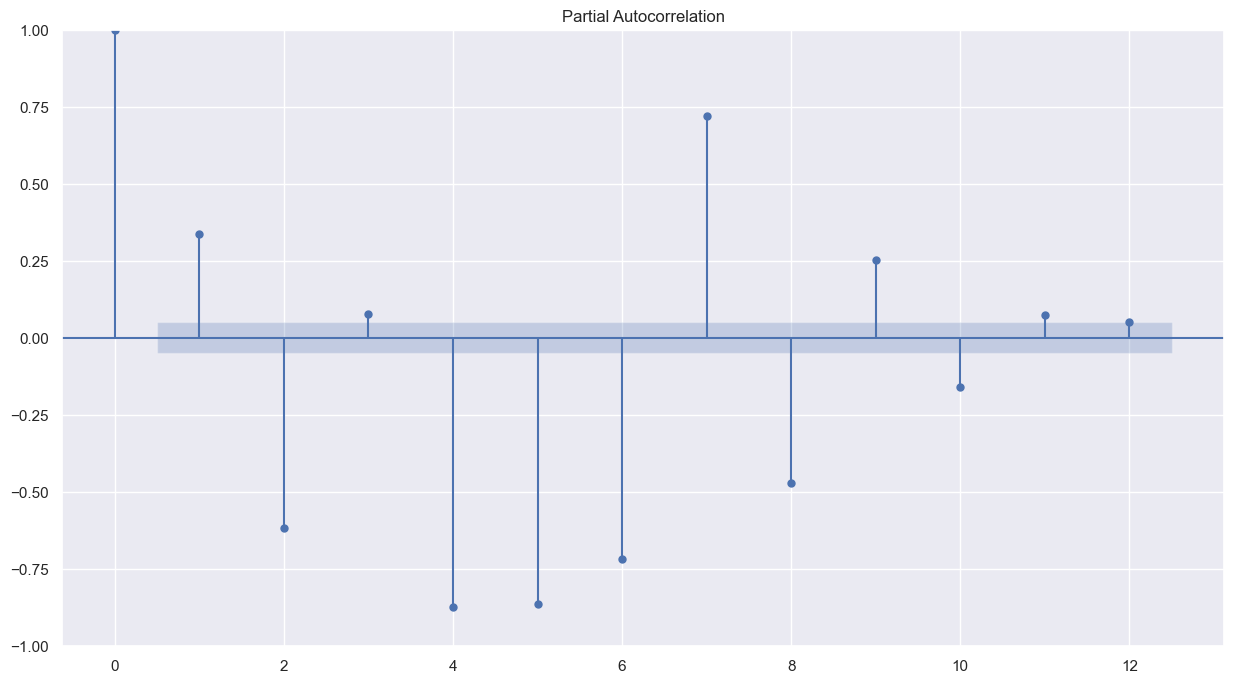

In [20]:

result = seasonal_decompose(tmp['sales'], model='additive', period=7)
seasonal = result.seasonal


plot_pacf(seasonal, lags =12);

## `Q`

first cutoff occurs at 1 --> `Q`=1

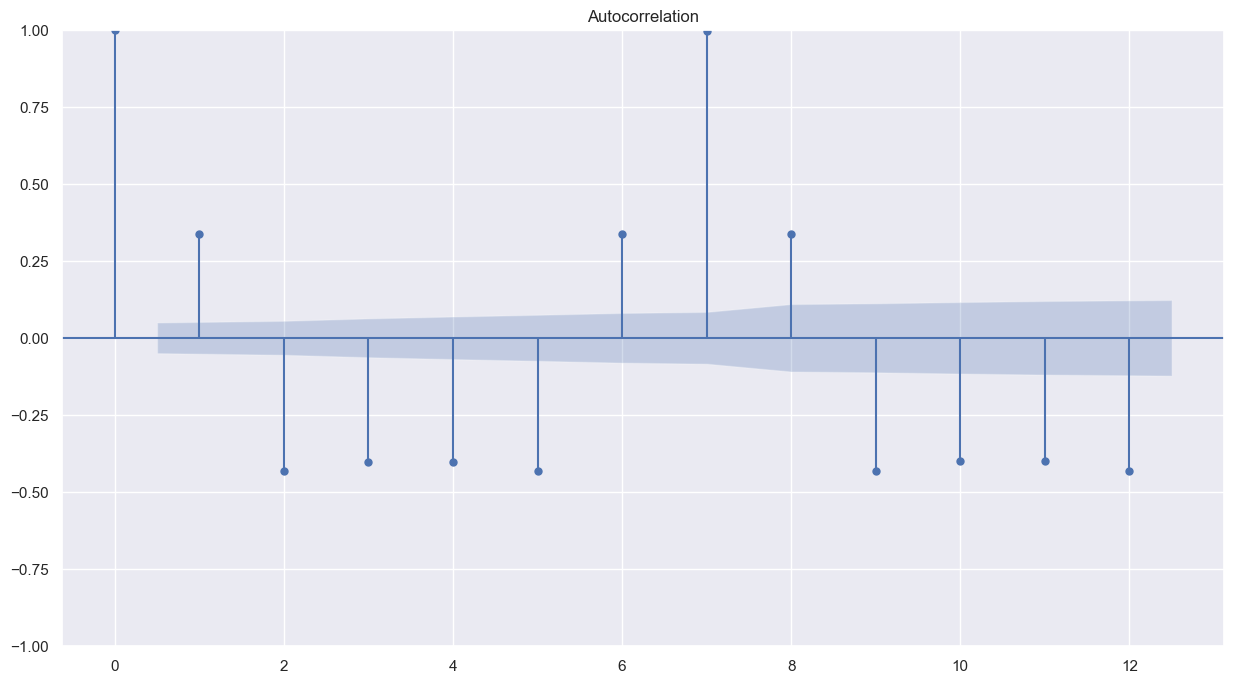

In [19]:

result = seasonal_decompose(tmp['sales'], model='additive', period=7)
seasonal = result.seasonal

plot_acf(seasonal, lags =12);